# Multioutput Examples with Integrated Human Microbiome Project Data

In [1]:
# Setup
import pandas as pd
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from waveome import model_search, regularization, kernels

In [118]:
# Data
# Read in metabolomics data
mbx = pd.read_csv('./data/iHMP_labeled_metabolomics.csv')
# Subset metabolites to labeled sets

# Get metabolite list
mbx_list = mbx.Metabolite
# Reshape metabolites for merge
mbx = mbx.iloc[:,7:].transpose().rename(columns = mbx_list)
# Only keep metabolites that have at least 20% non-missing values
mbx_list = mbx_list[(mbx.notna().mean() >= 0.2).values]
mbx = mbx[mbx_list]

# Read in metadata for timing of samples
meta = pd.read_csv('./data/iHMP_metadata.csv')
# Subset metadata to appropriate samples and columns of interest
meta = meta[meta['External ID'].isin(mbx.index)][['External ID', 'Participant ID', 
                                                  'date_of_receipt', 'diagnosis',
                                                  'hbi', 'sccai', 'race', 'sex',
                                                  #'Age at diagnosis', 'consent_age',
                                                  #'site_name'
                                                 ]]
meta.set_index('External ID', inplace=True)

# Combine severity scores
meta['severity'] = np.where(meta['diagnosis'] == 'CD', meta.hbi, meta.sccai)

# Make sure that intensities are numeric and log transform them
log_mbx = np.log(mbx.astype('double'))

# Calculate the means and standard deviations of each column
log_means = log_mbx.mean()
log_stds = log_mbx.std()

# Transform dataset
log_mbx = (log_mbx - log_means)/log_stds

# Merge metabolomics info to metadata
df = (meta.merge(mbx, #log_mbx, 
                 left_index = True, 
           right_index = True).
      drop_duplicates().
      rename(columns = {'Participant ID': 'id',
                        'date_of_receipt': 'date'#,
#                         0: 'intensity'
                       }))

# Fix the date column
df.date = pd.to_datetime(df.date)

# Now scale the dates compared to the earliest date
min_date = df.date.min()
df['days_from_start'] = (df.date - min_date).dt.days

# Find the max severity day for each ID
max_date = df[['id', 'severity', 'date']].\
    dropna(subset=['severity']).\
    sort_values(['severity', 'date'], ascending=[True, False]).\
    groupby('id').\
    tail(1).\
    drop(columns=['severity']).\
    rename(columns={'date': 'max_severity_date'})

# Merge this back to df
df = pd.merge(df, max_date, on='id')
df['days_from_max_severity'] = (df.date - df.max_severity_date).dt.days
df = df.drop(columns=['max_severity_date'])

# Drop columns that aren't needed (drop id for the moment)
df = df.drop(columns=['date'])#, 'id'])

# Drop duplicate metabolites
df = df.loc[:,~df.columns.duplicated()]

# Only keep CD observations because they have hbi
df = df.query("diagnosis == 'CD'").drop(columns = ['diagnosis'])

# Only keep non-missing severity for the moment
# df = df[df.hbi.notna()]

# Fill in severity scores for individuals, last carry forward 
df['severity'] = df[['id', 'severity']].\
    groupby('id').\
    fillna(method='ffill')
df = df[df.severity.notna()]
df = df.drop(columns=['hbi', 'sccai'])

# Store individual information look up vectors
# Get numerics for each categorical value as well as the lookup index
df['id'], id_map = pd.factorize(df['id'])
# df['diagnosis'], diagnosis_map = pd.factorize(df['diagnosis'])
df['race'], race_map = pd.factorize(df['race'])
df['sex'], sex_map = pd.factorize(df['sex'])
# n_id = df.id.nunique()
# id_list = df.id.unique()
# id_vals = df.id.values
# id_idx = np.array([np.where(id_list == x)[0][0] for x in id_vals])
# df['id'] = id_idx

# Only keep metabolites 
df_original = df.copy()

# Filter to only moderate or greater cases
mod_ids = df.groupby("id", as_index=False).severity.max().query("severity >= 4").id
df = df[df.id.isin(mod_ids)]

# Standardize severity and days for convergence properties
df.days_from_start = (df.days_from_start - df.days_from_start.mean())/df.days_from_start.std()
# df.days_from_max_severity = (df.days_from_max_severity - df.days_from_max_severity.mean())/df.days_from_max_severity.std()
dfms_sd = df.days_from_max_severity.std()
df.days_from_max_severity = (df.days_from_max_severity)/df.days_from_max_severity.std()
df.severity = (df.severity - df.severity.mean())/df.severity.std()

# Sort
df = df.sort_values(["id", "days_from_start"])

# Normalize columns
# df.days_from_start = (df.days_from_start.max() - df.days_from_start)/(df.days_from_start.max()-df.days_from_start.min())
# df.hbi = (df.hbi.max() - df.hbi)/(df.hbi.max() - df.hbi.min())
# df.id = (df.id.max() - df.id)/(df.id.max() - df.id.min())
# df.id = (df.id - df.id.mean())/df.id.std()
print(df.shape)
df.head()

(159, 550)


/var/folders/2w/r7x976td4f97twg4r5ff50500000gn/T/ipykernel_3118/794461704.py:15: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('./data/iHMP_metadata.csv')


,id,race,sex,severity,12.13-diHOME,9.10-diHOME,caproate,heptanoate,hydrocinnamate,mandelate,...,C18:1 LPC plasmalogen,C18:0 LPE-A,C18:0 LPE-B,C22:6 LPE,sphingosine-isomer1,sphingosine-isomer2,sphingosine-isomer3,C14:0 SM,days_from_start,days_from_max_severity
0,0,0,0,0.284992,942546.0,1418451.0,2194.0,NaN,38180.0,5893.0,...,453688.0,9997928.0,3579319.0,2066660.0,274385476.0,136360623.0,211906815.0,36328.0,-1.665052,-1.810916
1,0,0,0,-0.050665,584730.0,1955625.0,2305.0,NaN,69475.0,10406.0,...,130737.0,16335239.0,13177075.0,4447184.0,121055143.0,65245288.0,301546342.0,51577.0,-1.390070,-1.436704
2,0,0,0,-0.050665,555437.0,739486.0,670.0,NaN,9780.0,6117.0,...,3760.0,4371214.0,2130907.0,10511485.0,199161782.0,106462063.0,118183128.0,NaN,-1.085627,-1.022399
3,0,0,0,0.284992,937676.0,1002635.0,1295.0,NaN,17147.0,9764.0,...,18460.0,3306645.0,2323331.0,1555152.0,187973992.0,97169686.0,72151914.0,NaN,-0.682975,-0.474447
4,0,0,0,1.291964,1286163.0,1453551.0,2920.0,NaN,23123.0,6514.0,...,NaN,8323839.0,2529248.0,4901090.0,152639719.0,79560140.0,225812346.0,6212.0,-0.334338,0.000000


In [122]:
df.id.nunique()

30

In [119]:
mbx_original = pd.read_csv('./data/iHMP_labeled_metabolomics.csv')
mbx_original.head()

,Method,Pooled QC sample CV,m/z,RT,HMDB (*Representative ID),Metabolite,Compound,HSM5FZBJ,MSM5FZ9X,CSM5FZ3N,...,MSMB4LZC,MSMB4LZR,MSMB4LZ8,HSMA33SK,MSMB4LYH,PSMB4MC5,HSMA33RX,HSMA33RL,MSMB4LYB,MSMB4LZK
0,C18-neg,0.027194,313.2387,9.75,HMDB04705,12.13-diHOME,C18n_QI06,4355470.0,2623839.0,942546.0,...,2286333.0,384886.0,920518.0,295487.0,1009373.0,2421531.0,1685079.0,2054717.0,1655387.0,1982374.0
1,C18-neg,0.026413,313.2387,9.95,HMDB04704,9.10-diHOME,C18n_QI07,1512589.0,2299190.0,1418451.0,...,1957142.0,313876.0,1145722.0,270803.0,974763.0,1000980.0,1536293.0,1337477.0,1649427.0,1170889.0
2,C18-neg,0.046836,115.0752,5.79,HMDB00535,caproate,C18n_QI08,9636.0,100.0,2194.0,...,2316.0,186.0,1476.0,42577.0,20963.0,272.0,14318.0,209334.0,5727.0,319.0
3,C18-neg,0.074083,129.0909,7.43,HMDB00666,heptanoate,C18n_QI09,NaN,NaN,NaN,...,75.0,NaN,NaN,36838.0,15718.0,NaN,25.0,4427.0,35.0,NaN
4,C18-neg,0.024138,149.0597,5.81,HMDB00764,hydrocinnamate,C18n_QI10,40871.0,8382.0,38180.0,...,382013.0,21418.0,1722039.0,113509.0,583775.0,28097.0,15229.0,1496165.0,73931.0,6530.0


X = [[ 0.         -1.81091553]
 [ 0.         -1.4367042 ]
 [ 0.         -1.0223988 ]
 [ 0.         -0.4744465 ]
 [ 0.          0.        ]]
Y = [[2.194000e+03 1.000000e+00 3.260110e+05 2.265412e+06]
 [2.305000e+03 1.000000e+00 3.638920e+05 2.336085e+06]
 [6.700000e+02 1.000000e+00 9.427700e+04 2.483180e+05]
 [1.295000e+03 1.000000e+00 8.083900e+04 5.744880e+05]
 [2.920000e+03 1.000000e+00 2.217740e+05 1.277464e+06]]


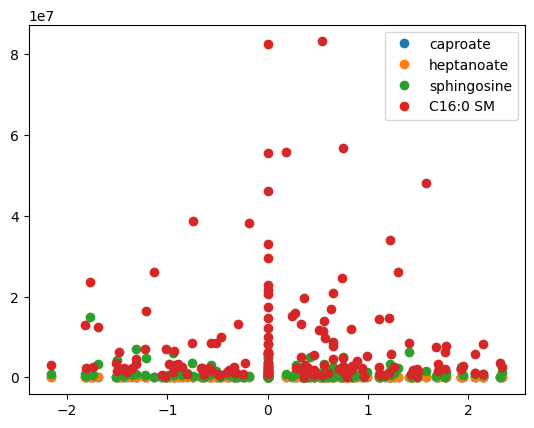

In [120]:
X = df[["id", "days_from_max_severity"]].to_numpy()
# X = df[["days_from_max_severity"]].to_numpy().reshape(-1, 1)
Y = df[["caproate", "heptanoate", "sphingosine", "C16:0 SM"]].to_numpy()

# If NA value in intensity then replace with small value
Y[np.isnan(Y)] = 1.

# Now transform Y values
# Y = (np.log(Y) - np.log(Y).mean(axis=0))/np.log(Y).std(axis=0)
# Y = Y - Y.mean(axis=0)

print(f"X = {X[:5, :]}")
print(f"Y = {Y[:5, :]}")

# plt.scatter(X, Y[:, 0], label="caproate")
# plt.scatter(X, Y[:, 1], label="sphingosine")
# plt.scatter(X, Y[:, 2], label="C16:0 SM")
plt.plot(X[:, 1], Y, 'o', label=["caproate", "heptanoate", "sphingosine", "C16:0 SM"])
plt.legend()
plt.show()

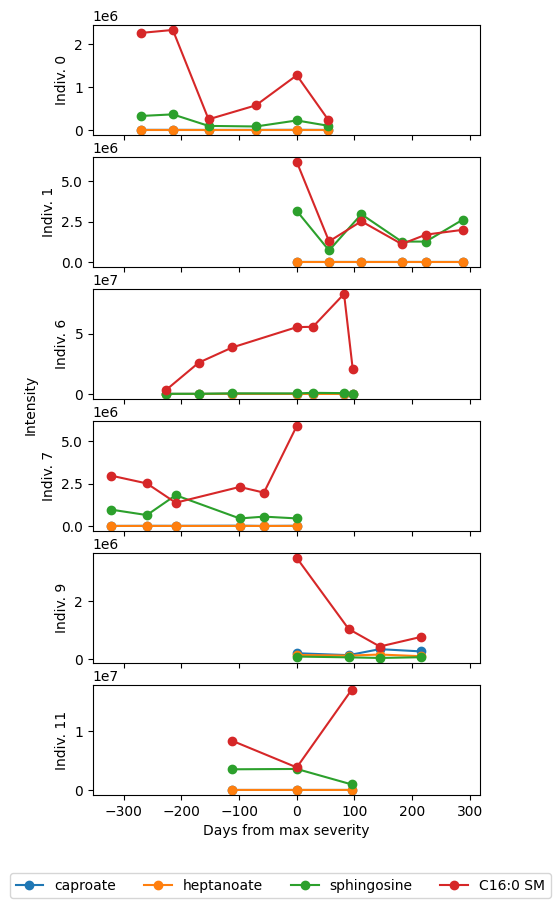

In [121]:
# Plot a few trajectories for some individuals
X = df[["id", "days_from_max_severity"]].to_numpy()
# X = df[["days_from_max_severity"]].to_numpy().reshape(-1, 1)
Y = df[["caproate", "heptanoate", "sphingosine", "C16:0 SM"]].fillna(0).to_numpy()

figs, axs = plt.subplots(6, 1, sharex = True, figsize=(5, 10), squeeze=True)
for i, id in enumerate(mod_ids[:6]):
    axs[i].plot(dfms_sd*X[X[:,0] == id, 1], Y[X[:, 0] == id], marker='o', label=["caproate", "heptanoate", "sphingosine", "C16:0 SM"])
    axs[i].set_ylabel(f"Indiv. {id}")
    # axs[i].ticklabel_format(style="plain")
axs[i].set_xlabel(xlabel="Days from max severity")
handles, labels = axs[i].get_legend_handles_labels()
figs.legend(handles, labels, loc="lower center", ncol=4, bbox_to_anchor=(0.5, 0.0))
figs.text(0.0, 0.5, 'Intensity', ha="center", va="center", rotation="vertical")
plt.show()

In [125]:
# Fit multioutput model
# num_gps = 6
X = df[["id", "race", "sex", "severity", "days_from_max_severity", "days_from_start"]].to_numpy()
# Y = np.log(df.drop(columns=["id", "race", "sex", "severity", "days_from_max_severity", "days_from_start"]).fillna(1).to_numpy())
Y = df.drop(columns=["id", "race", "sex", "severity", "days_from_max_severity", "days_from_start"]).fillna(1).to_numpy()

# Now try to standardize to nullify the shape parameter
# MOM: k = E[X]^2/V[X]
k_hat = (Y.mean(axis=0))**2/Y.var(axis=0)
Y = Y/k_hat

full_kernel, kernel_string = regularization.lasso_kernel_build(
    cat_vars=[0, 1, 2],
    num_vars=[3, 4, 5],
    var_names=["id", "race", "sex", "severity", "days_from_max_severity", "days_from_start"],
    second_order_numeric=True,
    kerns=[gpflow.kernels.SquaredExponential(), gpflow.kernels.Matern12()]
)

# Drop initial categorical columns because of convergence issues
# full_kernel = full_kernel[3:]
# kernel_string = kernel_string[3:]

cv_out_multi = regularization.lam_search(
    kernel=gpflow.kernels.LinearCoregionalization(
        kernels=full_kernel,
        W=np.ones(shape=(np.shape(Y)[1], len(full_kernel)))
    ),
    X=X,
    Y=Y,
    lam_list=np.arange(start=0, stop=1.1, step=0.05), #[0., 0.2, 0.4, 0.6, 0.8, 1.],
    freeze_inducing=True,
    num_inducing_points=100,
    freeze_variances=True,
    random_seed=9102,
    verbose=True,
    unit_col=0,
    k_fold=5,
    likelihood=gpflow.likelihoods.Gamma(shape=np.ones(Y.shape[1])), # ~8m
    # likelihood=gpflow.likelihoods.Gaussian(variance=np.ones(Y.shape[1]))
    # max_iter=100000
)

lambda value = 0.0, gamma value = 0.0


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are use

New best log likelihood: -7711243731.379618
New best log likelihood: -55557410634.20195
New best log likelihood: -37117751911.47917
New best log likelihood: -29617045190.879707
New best log likelihood: -299648943.54691666
New best log likelihood: -35844068866.231895
New best log likelihood: -16367046327.25479
New best log likelihood: -1059659.4529337895
New best log likelihood: -1503172281.3271997
New best log likelihood: -9799175511.656986
New best log likelihood: -22936327666.13083
Model: [], BIC: 15422487770.76
Model: [], BIC: 3006344870.65
Model: [], BIC: 19598351331.31
New best log likelihood: -18636540120.357384
Model: [], BIC: 37273080548.71
Model: [], BIC: 2119626.91
ll = -665855.2107075017, se = 268397.14944940514
lambda value = 0.05, gamma value = 0.0
New best log likelihood: -17279824924.88387
New best log likelihood: -10003498927.40416
New best log likelihood: -3057322684.6459856
New best log likelihood: -25521832236.97572
New best log likelihood: -63165814559.87633
New bes

In [126]:
print(cv_out_multi["best_lambda"])
cv_out_multi["final_model"]

0.05


name,class,transform,prior,trainable,shape,dtype,value
SVPGPR.kernel.kernels[0].variance,Parameter,Softplus,,False,(),float64,1.0
SVPGPR.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,1.0
SVPGPR.kernel.kernels[2].variance,Parameter,Softplus,,False,(),float64,1.0
SVPGPR.kernel.kernels[3].variance,Parameter,Softplus,,False,(),float64,1.0
SVPGPR.kernel.kernels[3].lengthscales,Parameter,Softplus,Uniform,True,(),float64,9.27186
SVPGPR.kernel.kernels[4].variance,Parameter,Softplus,,False,(),float64,1.0
SVPGPR.kernel.kernels[4].lengthscales,Parameter,Softplus,Uniform,True,(),float64,9.0096
SVPGPR.kernel.kernels[5].variance,Parameter,Softplus,,False,(),float64,1.0
SVPGPR.kernel.kernels[5].lengthscales,Parameter,Softplus,Uniform,True,(),float64,4.14452
SVPGPR.kernel.kernels[6].variance,Parameter,Softplus,,False,(),float64,1.0


In [127]:
# "On" processes
W_ = cv_out_multi["final_model"].kernel.W.numpy()
W_norm = (np.abs(W_)/np.abs(W_).sum(axis=1)[:, None]).round(2)
cv_out_multi["final_model"].kernel.W

<Parameter: name=identity, dtype=float64, shape=[544, 51], fn="identity", numpy=
array([[ 3.96777175e-02,  8.25239504e-01,  1.43406900e+00, ...,
        -1.03978304e+00,  6.04561886e-01,  3.32828250e-01],
       [-2.98504078e-02,  1.03885532e+00, -6.96245258e-02, ...,
        -7.36840420e-01,  2.32124637e-01,  1.24892430e-02],
       [-1.70841674e+00, -5.59523865e-01, -1.21951118e+00, ...,
         4.54253927e-01, -1.34881167e+00, -6.77761396e-01],
       ...,
       [ 1.90578113e-01, -2.72841939e-01, -2.47206418e-03, ...,
         1.43149841e+00, -4.04694283e-01, -4.57924720e-02],
       [-5.41624253e-01, -8.42674686e-01,  3.21276533e+00, ...,
        -8.83060551e-01, -1.74184467e+00,  1.18004296e+00],
       [-3.82993755e-01,  2.11455172e-01,  7.48276431e-02, ...,
         7.46111301e-01,  6.86136609e-01,  3.56205276e-01]])>

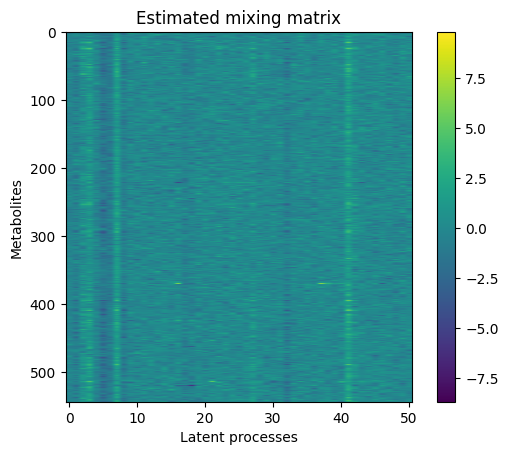

In [128]:
plt.imshow(cv_out_multi["final_model"].kernel.W, aspect=0.1)
plt.colorbar()
plt.title("Estimated mixing matrix")
plt.ylabel("Metabolites")
plt.xlabel("Latent processes")
plt.show()

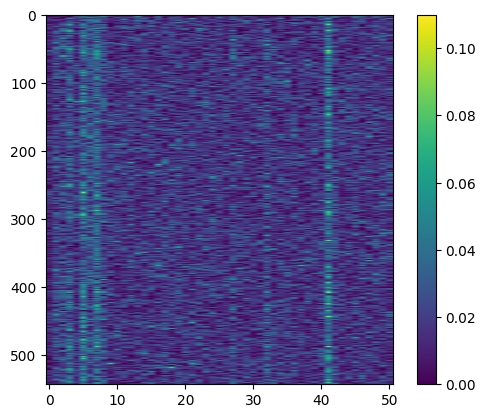

In [129]:
plt.imshow(W_norm, aspect=0.1)
plt.colorbar()
plt.show()

['squared_exponential[days_from_max_severity]*squared_exponential[days_from_max_severity]'
 'squared_exponential[days_from_max_severity]'
 'squared_exponential[days_from_start]' 'squared_exponential[severity]']


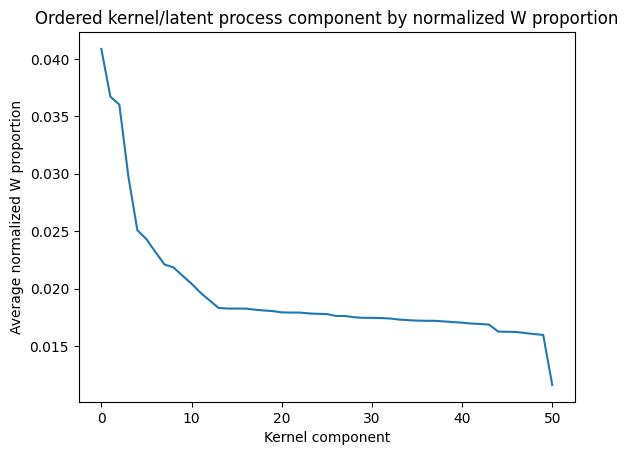

In [174]:
plt.plot(range(len(W_norm.mean(axis=0))), W_norm.mean(axis=0)[np.argsort(W_norm.mean(axis=0))[::-1]])
plt.xlabel("Kernel component")
plt.ylabel("Average normalized W proportion")
plt.title("Ordered kernel/latent process component by normalized W proportion")
print(np.array(kernel_string)[np.argsort(W_norm.sum(axis=0))[::-1]][:4])

['squared_exponential[days_from_max_severity]*squared_exponential[days_from_max_severity]'
 'squared_exponential[days_from_max_severity]'
 'squared_exponential[days_from_start]' 'squared_exponential[severity]']


Text(0.5, 0, 'Days from max severity (std.)')

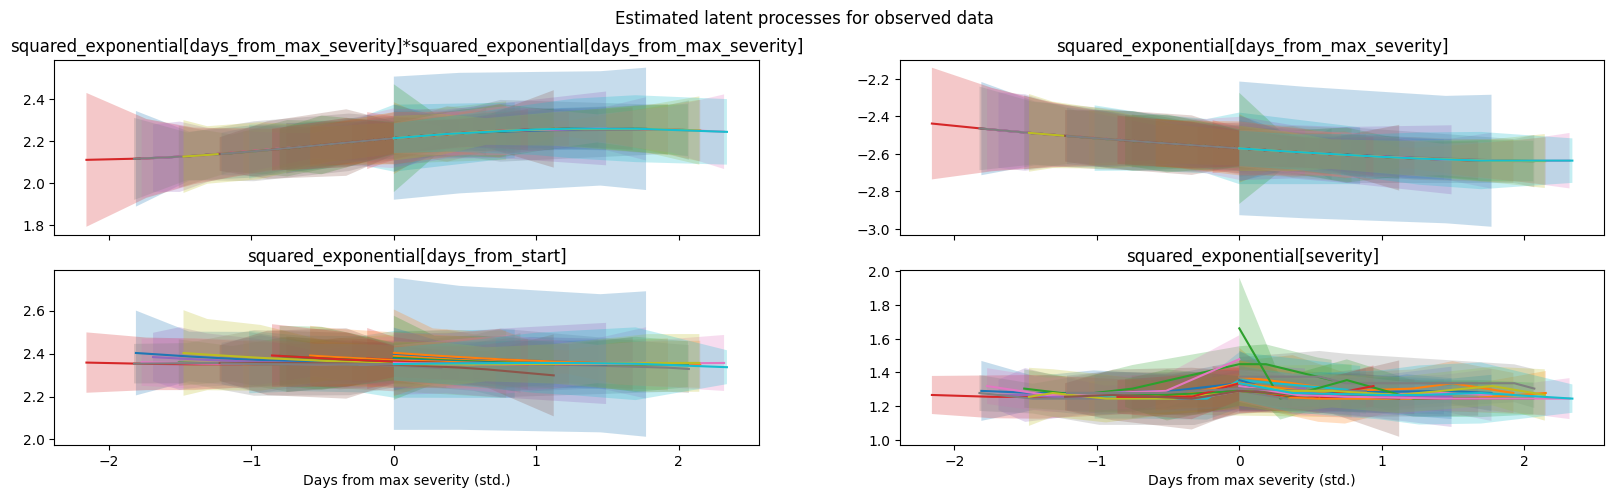

In [177]:
plot_axis = 4

X_sorted = X[np.argsort(X[:, plot_axis])]

mu_hat, var_hat = cv_out_multi["final_model"].predict_f(X_sorted)#, full_output_cov=True)

# keep_gps = W_norm.mean(axis=0) > 0.05
keep_gps = np.argsort(W_norm.mean(axis=0))[::-1][:4]
print(np.array(kernel_string)[keep_gps])
# Get latent mean
l_mu_hat = mu_hat.numpy() @ np.transpose(np.linalg.pinv(W_))[:, keep_gps]

# Center means
# l_mu_hat = l_mu_hat - tf.math.reduce_mean(l_mu_hat, axis=0)

# Get latent variances
l_var_hat = np.transpose(np.linalg.pinv((W_[:, keep_gps])**2) @ np.transpose(var_hat))

# Now plot latents
n_row = int(np.floor(np.sqrt(len(keep_gps))))
n_col = int(np.ceil(np.sqrt(len(keep_gps))))
figs, axs = plt.subplots(n_row, n_col, figsize=(20,5), sharex=True)
row_c = 0
for i in range(len(keep_gps)):
    for idx in np.unique(X[:, 0]):
        axs[row_c, i % n_col].fill_between(
            x=X_sorted[X_sorted[:, 0] == idx, plot_axis].flatten(), 
            y1=l_mu_hat[X_sorted[:, 0] == idx,i] - 1.96*np.sqrt(l_var_hat[X_sorted[:, 0] == idx, i]),
            y2=l_mu_hat[X_sorted[:, 0] == idx,i] + 1.96*np.sqrt(l_var_hat[X_sorted[:, 0] == idx, i]),
            alpha=0.25
        )
        axs[row_c, i % n_col].plot(X_sorted[X_sorted[:, 0] == idx, plot_axis], l_mu_hat[X_sorted[:, 0] == idx,i])

    # Set subplot title to kernel component
    axs[row_c, i % n_col].set_title(np.array(kernel_string)[keep_gps][i])
    if i % n_col == n_col - 1:
        row_c += 1

plt.suptitle("Estimated latent processes for observed data")
axs[1, 0].set_xlabel("Days from max severity (std.)")
axs[1, 1].set_xlabel("Days from max severity (std.)")

(array([120., 165., 113.,  74.,  43.,  18.,   8.,   1.,   1.,   1.]),
 array([0.06577451, 0.40220511, 0.73863571, 1.07506631, 1.41149691,
        1.74792751, 2.08435811, 2.42078871, 2.75721931, 3.09364991,
        3.43008051]),
 <BarContainer object of 10 artists>)

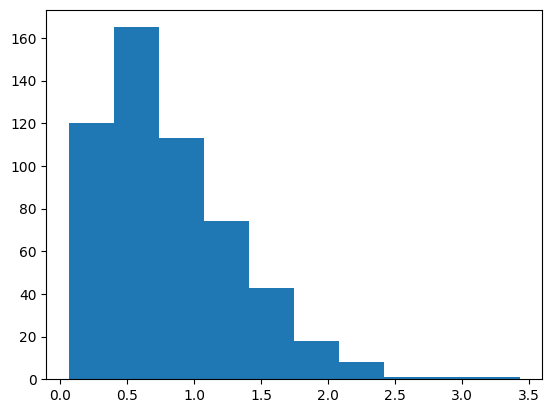

In [117]:
plt.hist(cv_out_multi["final_model"].likelihood.shape.numpy())

(array([ 3.,  1.,  3., 11., 10., 11., 12., 11.,  5.,  6.]),
 array([5.22423372, 5.37851328, 5.53279284, 5.6870724 , 5.84135196,
        5.99563152, 6.14991108, 6.30419064, 6.4584702 , 6.61274976,
        6.76702932]),
 <BarContainer object of 10 artists>)

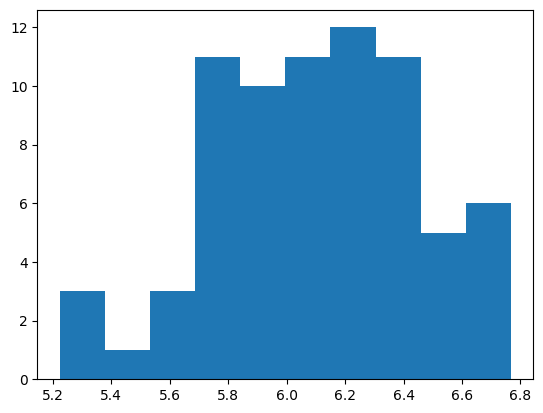

In [106]:
plt.hist(mu_hat.numpy()[:, 0])

(array([ 8., 30., 14., 10.,  4.,  3.,  3.,  0.,  0.,  1.]),
 array([ 214.30442714,  458.4424909 ,  702.58055466,  946.71861843,
        1190.85668219, 1434.99474595, 1679.13280971, 1923.27087347,
        2167.40893724, 2411.547001  , 2655.68506476]),
 <BarContainer object of 10 artists>)

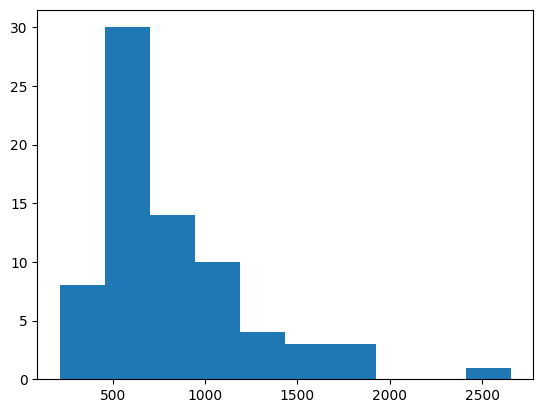

In [107]:
mu_hat, y_var_hat = cv_out_multi["final_model"].predict_y(X_sorted)#, full_output_cov=True)
plt.hist(y_hat.numpy()[:, 0])

(array([29., 17., 12.,  3.,  6.,  4.,  0.,  1.,  0.,  1.]),
 array([ 131182.27716557,  625244.35390111, 1119306.43063666,
        1613368.5073722 , 2107430.58410775, 2601492.66084329,
        3095554.73757884, 3589616.81431438, 4083678.89104993,
        4577740.96778547, 5071803.04452102]),
 <BarContainer object of 10 artists>)

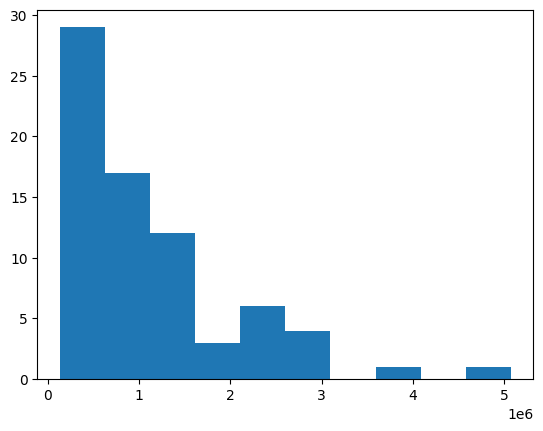

In [108]:
# plt.hist(np.log(Y[:, 0]))
plt.hist(Y[:, 0])

Text(0.5, 1.0, 'Proportion explained by severity kernel')

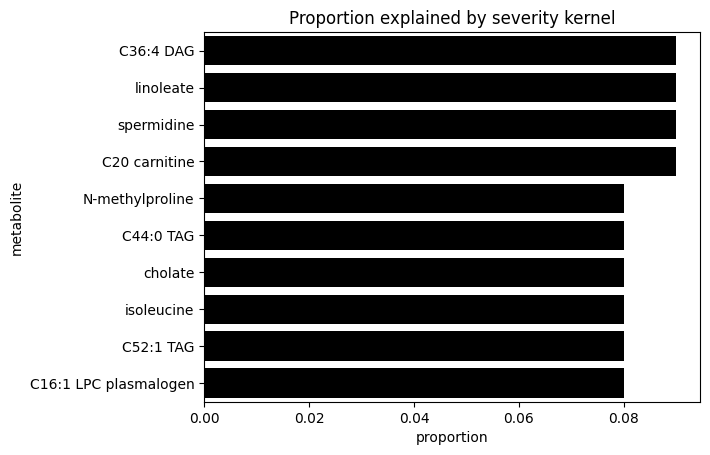

In [172]:
# Pull off specific latent GP loadings
dms_df = pd.DataFrame(
    {
        "metabolite": df.drop(columns=["id", "race", "sex", "severity", "days_from_max_severity", "days_from_start"]).columns.values,
        "proportion": W_norm[:, np.array(kernel_string) == "squared_exponential[severity]"].flatten().astype(float)
    }
)

dms_df = dms_df.sort_values("proportion", ascending=False).reset_index()
p = sns.barplot(
    data=dms_df.iloc[:10, :],
    y="metabolite",
    x="proportion",
    color="black"
)
p.set_title("Proportion explained by severity kernel")

In [166]:
X_pred = np.zeros(shape=(500, X.shape[1]))
X_pred[:, 3] = np.linspace(start=X[:, 3].min(), stop=X[:, 3].max(), num=500)

In [167]:
# Look at marginal plot of time around max
mu_pred_new, var_pred_new = cv_out_multi["final_model"].predict_f(X_pred)

In [168]:
top_mbx_idx = df.drop(columns=["id", "race", "sex", "severity", "days_from_max_severity", "days_from_start"]).columns.isin(dms_df.metabolite[:5].values)
mu_hat_sub = mu_pred_new.numpy()[:, top_mbx_idx]
var_hat_sub = var_pred_new.numpy()[:, top_mbx_idx]

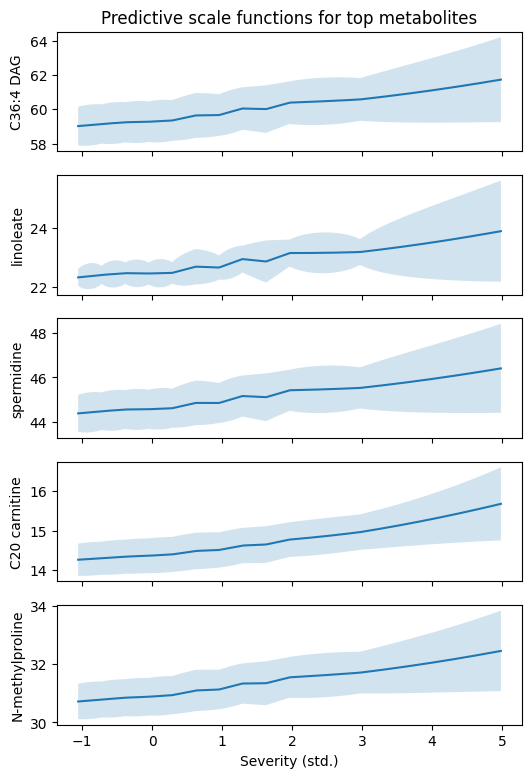

In [171]:
figs, axs = plt.subplots(5, 1, figsize=(6, 9), sharex=True)
for i in range(5):
    # for idx in np.unique(X_pred[:, 0]):
    # axs[i, 0].plot(
    axs[i].fill_between(
        # x=X_sorted[X_sorted[:, 0] == idx, plot_axis].flatten(), 
        # y1=mu_hat_sub[X_sorted[:, 0] == idx,i] - 0, # 1.96*np.sqrt(y_var_hat_sub[X_sorted[:, 0] == idx, i]),
        # y2=mu_hat_sub[X_sorted[:, 0] == idx,i] + 0, #1.96*np.sqrt(y_var_hat_sub[X_sorted[:, 0] == idx, i]),
        x=X_pred[:, 3].flatten(),
        y1=mu_hat_sub[:, i]-1.96*np.sqrt(var_hat_sub[:, i]),
        y2=mu_hat_sub[:, i]+1.96*np.sqrt(var_hat_sub[:, i]),
        alpha=0.2
    )
        # axs[i, 0].plot(X_sorted[X_sorted[:, 0] == idx, plot_axis], mu_hat_sub[X_sorted[:, 0] == idx,i])
    axs[i].plot(X_pred[:, 3].flatten(), mu_hat_sub[:, i])

    # Set subplot title to kernel component
    axs[i].set_ylabel(dms_df.metabolite.values[i])

# for i in range(5):
#     for idx in np.unique(X[:, 0]):
#         axs[i, 1].fill_between(
#             x=X_sorted[X_sorted[:, 0] == idx, plot_axis].flatten(), 
#             y1=mu_hat_sub[X_sorted[:, 0] == idx,i] - 1.96*np.sqrt(var_hat_sub[X_sorted[:, 0] == idx, i]),
#             y2=mu_hat_sub[X_sorted[:, 0] == idx,i] + 1.96*np.sqrt(var_hat_sub[X_sorted[:, 0] == idx, i]),
#             alpha=0.25
#         )
#         axs[i, 1].plot(X_sorted[X_sorted[:, 0] == idx, plot_axis], mu_hat_sub[X_sorted[:, 0] == idx,i])

    # Set subplot title to kernel component
    # axs[i, 1].set_title(dms_df.metabolite.values[i])
axs[4].set_xlabel("Severity (std.)")
# axs[4, 1].set_xlabel("Days from  max severity (std.)")
axs[0].set_title("Predictive scale functions for top metabolites")
plt.show()

In [25]:
# plt.imshow(m.kernel.W, cmap="Blues")
# for (j,i),label in np.ndenumerate(m.kernel.W.numpy().round(1)):
#     plt.text(i,j,label,ha='center',va='center')
# plt.colorbar()

Log posterior density = -18160.856765925393


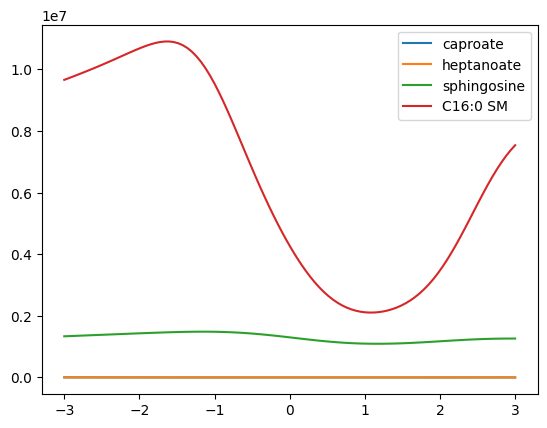

In [ ]:
print(f"Log posterior density = {m.log_posterior_density(data=(X,Y))}")
# Now print out the predicted values
x_new = np.linspace(start=-3, stop=3, num=100).reshape(-1, 1)
# Add on person ID indicator
x_new = np.hstack((np.repeat(1, len(x_new)).reshape(-1, 1), x_new))
mu_hat, var_hat = m.predict_y(x_new)
plt.plot(x_new[:, 1], mu_hat, label=["caproate", "heptanoate", "sphingosine", "C16:0 SM"])
# plt.plot(x_new, mu_hat[:, 0], label="caproate")
# # plt.fill_between(x_new.flatten(), y1=mu_hat[:, 0]-1.96*np.sqrt(var_hat[:, 0]), y2=mu_hat[:, 0]+1.96*np.sqrt(var_hat[:, 0]))
# plt.plot(x_new, mu_hat[:, 1], label="sphingosine")
# plt.plot(x_new, mu_hat[:, 2], label="C16:0 SM")
plt.legend()
plt.show()

In [ ]:
## Uncomment this to look at the predicted and actual values
# figs, axs = plt.subplots(1, 2, figsize=(10, 3))
# sns.regplot(x=x_new[:, 1], y=mu_hat[:, 3], lowess=True, ax=axs[0])
# sns.regplot(x=X[:, 1], y=Y[:, 3], lowess=True, ax=axs[1])

In [ ]:
print(f"Log posterior density = {m.log_posterior_density(data=(X,Y))}") # -18,723.65


Log posterior density = -19185.41672015724


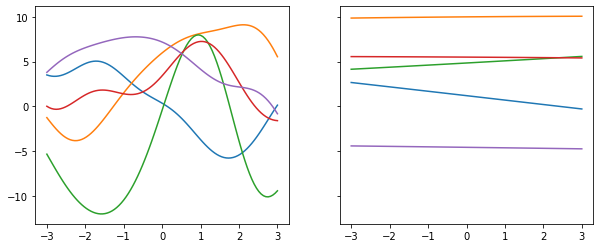

In [ ]:
# Inference in latent space
np.random.seed(9102)
lrv1 = np.random.multivariate_normal(
    mean=np.zeros_like(x_new.flatten()),
    cov=m.kernel.latent_kernels[0].K(x_new),
    size=5
).T

lrv2 = np.random.multivariate_normal(
    mean=np.zeros_like(x_new.flatten()),
    cov=m.kernel.latent_kernels[1].K(x_new),
    size=5
).T

figs, axs = plt.subplots(1, 2, sharey=True, figsize=(10,4))
axs[0].plot(x_new, lrv1)
axs[1].plot(x_new, lrv2)
plt.show()


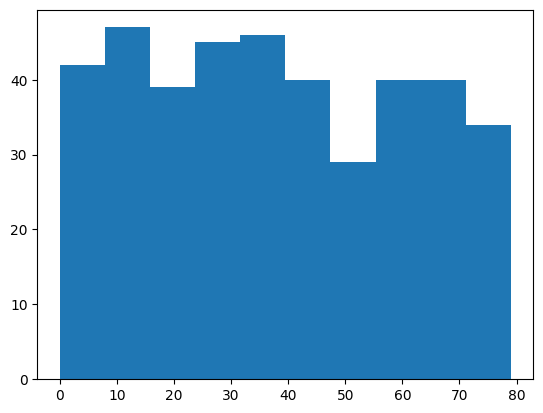

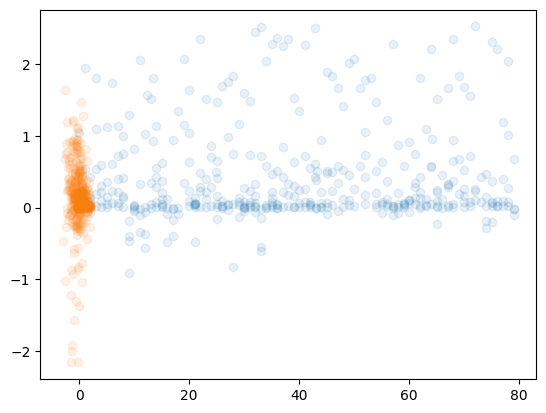

In [ ]:
# What do the latent points look like?
plt.hist(m.inducing_variable.inducing_variable_list[0].Z.numpy()[:, 0])
plt.show()
plt.plot(m.inducing_variable.inducing_variable_list[0].Z.numpy(), m.q_mu.numpy(), 'o', alpha=0.1)

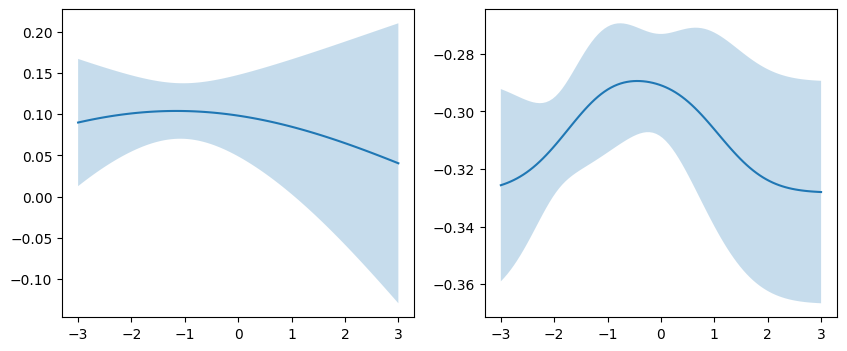

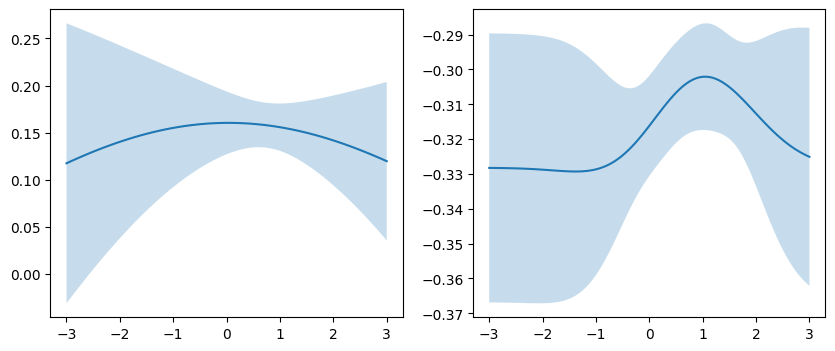

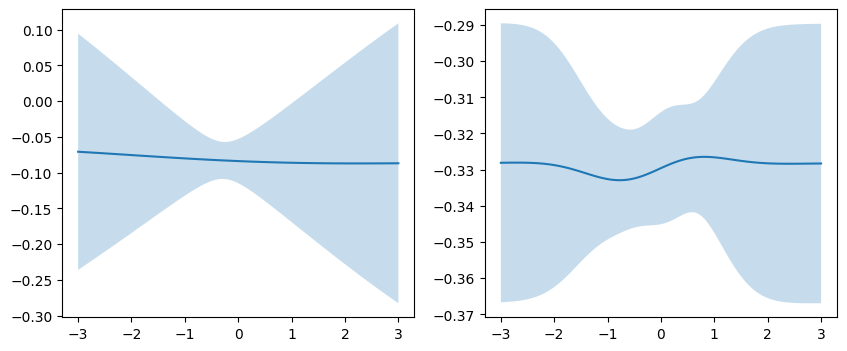

In [ ]:

for id_ in range(3):
    # Add on person ID indicator
    x_new = np.linspace(start=-3, stop=3, num=100).reshape(-1, 1)
    x_new = np.hstack((np.repeat(id_, len(x_new)).reshape(-1, 1), x_new))

    mu_hat, var_hat = m.predict_f(x_new)#, full_output_cov=True)

    # Get latent mean
    l_mu_hat = mu_hat @ tf.transpose(tf.linalg.pinv(m.kernel.W))

    # Center means
    # l_mu_hat = l_mu_hat - tf.math.reduce_mean(l_mu_hat, axis=0)

    # Get latent variances
    l_var_hat = tf.transpose(tf.linalg.pinv((m.kernel.W)**2) @ tf.transpose(var_hat))

    # Now plot latents
    figs, axs = plt.subplots(1, num_latent_gps, figsize=(10,4))
    for i in range(num_latent_gps):
        if num_latent_gps > 1:
            axs[i].fill_between(
                x=x_new[:, 1], 
                y1=l_mu_hat[:,i] - 1.96*np.sqrt(l_var_hat[:, i]),
                y2=l_mu_hat[:,i] + 1.96*np.sqrt(l_var_hat[:, i]),
                alpha=0.25
            )
            axs[i].plot(x_new[:, 1], l_mu_hat[:,i])
        else:
            axs.fill_between(
                x=x_new[:, 1], 
                y1=l_mu_hat[:,i] - 1.96*np.sqrt(l_var_hat[:, i]),
                y2=l_mu_hat[:,i] + 1.96*np.sqrt(l_var_hat[:, i]),
                alpha=0.25
            )
            axs.plot(x_new[:, 1], l_mu_hat[:,i])
